(rosen_schooling_model)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

```{index} single: python
```

# Rosen Schooling Model

```{contents} Contents
:depth: 2
```

This lecture is yet another part of a suite of lectures that use the quantecon DLE class to instantiate models within the
{cite}`HS2013` class of models described in detail in {doc}`Recursive Models of Dynamic Linear Economies <hs_recursive_models>`.

In addition to what's included in  Anaconda, this lecture uses the quantecon library

In [1]:
!pip install --upgrade quantecon

We'll also need the following imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from quantecon import LQ
from collections import namedtuple
from quantecon import DLE
from math import sqrt
%matplotlib inline

## A One-Occupation Model

Ryoo and Rosen's (2004) {cite}`ryoo2004engineering` partial equilibrium model determines

- a stock of "Engineers" $N_t$
- a number of new entrants in engineering school, $n_t$
- the wage rate of engineers, $w_t$

It takes k periods of schooling to become an engineer.

The model consists of the following equations:

- a demand curve for engineers:

$$
w_t = - \alpha_d N_t + \epsilon_{dt}
$$

- a time-to-build structure of the education process:

$$
N_{t+k} = \delta_N N_{t+k-1} + n_t
$$

- a definition of the discounted present value of each new engineering
  student:

$$
v_t = \beta_k \mathbb{E} \sum_{j=0}^\infty (\beta \delta_N)^j w_{t+k+j}
$$

- a supply curve of new students driven by present value $v_t$:

$$
n_t = \alpha_s v_t + \epsilon_{st}
$$

## Mapping into HS2013 Framework

We represent this model in the {cite}`HS2013` framework by

- sweeping the time-to-build structure and the demand for engineers
  into the household technology, and
- putting the supply of engineers into the technology for producing
  goods

### Preferences

$$
\Pi = 0, \Lambda=
\begin{bmatrix}
   \alpha_d & 0 & \cdots & 0
   \end{bmatrix}
, \Delta_h =
\begin{bmatrix}
   \delta_N & 1 & 0 & \cdots & 0 \\ 0 & 0 & 1 & \cdots & 0 \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 0 & \cdots& \cdots & 0 & 1 \\ 0 & 0 & 0 & \cdots & 0
   \end{bmatrix}
   , \Theta_h =
\begin{bmatrix}
   0 \\ 0 \\ \vdots \\ 0 \\ 1
   \end{bmatrix}
$$

where $\Lambda$ is a k+1 x 1 matrix, $\Delta_h$ is a k_1 x
k+1 matrix, and $\Theta_h$ is a k+1 x 1 matrix.

This specification sets $N_t = h_{1t-1}$, $n_t = c_t$,
$h_{\tau+1,t-1} = n_{t-(k-\tau)}$ for $\tau = 1,...,k$.

Below we set things up so that the number of years of education, $k$, can
be varied.

### Technology

To capture Ryoo and Rosen's {cite}`ryoo2004engineering` supply curve, we use the physical
technology:

$$
c_t = i_t + d_{1t}
$$

$$
\psi_1i_t = g_t
$$

where $\psi_1$ is inversely proportional to $\alpha_s$.

### Information

Because we  want $b_t = \epsilon_{dt}$ and $d_{1t} =\epsilon_{st}$, we set

$$
A_{22}=
\begin{bmatrix}
   1 & 0 & 0 \\ 0 & \rho_s & 0 \\ 0 & 0 & \rho_d
   \end{bmatrix}
,   C_2 =
\begin{bmatrix}
   0 & 0 \\ 1 & 0 \\ 0 & 1
   \end{bmatrix}
,   U_b =
\begin{bmatrix}
   30 & 0 & 1
   \end{bmatrix}
,   U_d =
\begin{bmatrix}
   10 & 1 & 0 \\ 0 & 0 & 0
   \end{bmatrix}
$$

where $\rho_s$ and $\rho_d$ describe the persistence of the
supply and demand shocks

In [3]:
Information = namedtuple('Information', ['a22', 'c2','ub','ud'])
Technology = namedtuple('Technology', ['ϕ_c', 'ϕ_g', 'ϕ_i', 'γ', 'δ_k', 'θ_k'])
Preferences = namedtuple('Preferences', ['β', 'l_λ', 'π_h', 'δ_h', 'θ_h'])

### Effects of Changes in Education Technology and Demand

We now study how changing

- the number of years of education required to become an engineer and
- the slope of the demand curve

affects responses to demand shocks.

To begin, we set $k = 4$ and $\alpha_d = 0.1$

In [4]:
k = 4  # Number of periods of schooling required to become an engineer

β = np.array([[1 / 1.05]])
α_d = np.array([[0.1]])
α_s = 1
ε_1 = 1e-7
λ_1 = np.full((1, k), ε_1)
# Use of ε_1 is trick to aquire detectability, see HS2013 p. 228 footnote 4
l_λ = np.hstack((α_d, λ_1))
π_h = np.array([[0]])

δ_n = np.array([[0.95]])
d1 = np.vstack((δ_n, np.zeros((k - 1, 1))))
d2 = np.hstack((d1, np.eye(k)))
δ_h = np.vstack((d2, np.zeros((1, k + 1))))

θ_h = np.vstack((np.zeros((k, 1)),
                 np.ones((1, 1))))

ψ_1 = 1 / α_s

ϕ_c = np.array([[1], [0]])
ϕ_g = np.array([[0], [-1]])
ϕ_i = np.array([[-1], [ψ_1]])
γ = np.array([[0], [0]])

δ_k = np.array([[0]])
θ_k = np.array([[0]])

ρ_s = 0.8
ρ_d = 0.8

a22 = np.array([[1,   0,   0],
                [0, ρ_s,   0],
                [0,   0, ρ_d]])

c2 = np.array([[0, 0], [10, 0], [0, 10]])
ub = np.array([[30, 0, 1]])
ud = np.array([[10, 1, 0], [0, 0, 0]])

info1 = Information(a22, c2, ub, ud)
tech1 = Technology(ϕ_c, ϕ_g, ϕ_i, γ, δ_k, θ_k)
pref1 = Preferences(β, l_λ, π_h, δ_h, θ_h)

econ1 = DLE(info1, tech1, pref1)

We create three other instances by:

1. Raising $\alpha_d$ to 2
1. Raising $k$ to 7
1. Raising $k$ to 10

In [5]:
α_d = np.array([[2]])
l_λ = np.hstack((α_d, λ_1))
pref2 = Preferences(β, l_λ, π_h, δ_h, θ_h)
econ2 = DLE(info1, tech1, pref2)

α_d = np.array([[0.1]])

k = 7
λ_1 = np.full((1, k), ε_1)
l_λ = np.hstack((α_d, λ_1))
d1 = np.vstack((δ_n, np.zeros((k - 1, 1))))
d2 = np.hstack((d1, np.eye(k)))
δ_h = np.vstack((d2, np.zeros((1, k+1))))
θ_h = np.vstack((np.zeros((k, 1)),
                 np.ones((1, 1))))

Pref3 = Preferences(β, l_λ, π_h, δ_h, θ_h)
econ3 = DLE(info1, tech1, Pref3)

k = 10
λ_1 = np.full((1, k), ε_1)
l_λ = np.hstack((α_d, λ_1))
d1 = np.vstack((δ_n, np.zeros((k - 1, 1))))
d2 = np.hstack((d1, np.eye(k)))
δ_h = np.vstack((d2, np.zeros((1, k + 1))))
θ_h = np.vstack((np.zeros((k, 1)),
                 np.ones((1, 1))))

pref4 = Preferences(β, l_λ, π_h, δ_h, θ_h)
econ4 = DLE(info1, tech1, pref4)

shock_demand = np.array([[0], [1]])

econ1.irf(ts_length=25, shock=shock_demand)
econ2.irf(ts_length=25, shock=shock_demand)
econ3.irf(ts_length=25, shock=shock_demand)
econ4.irf(ts_length=25, shock=shock_demand)

The first figure plots the impulse response of $n_t$ (on the left)
and $N_t$ (on the right) to a positive demand shock, for
$\alpha_d = 0.1$ and $\alpha_d = 2$.

When $\alpha_d = 2$, the number of new students $n_t$ rises
initially, but the response then turns negative.

A positive demand shock raises wages, drawing new students into the
profession.

However, these new students raise $N_t$.

The higher is $\alpha_d$, the larger the effect of this rise in
$N_t$ on wages.

This counteracts the demand shock's positive effect on wages, reducing
the number of new students in subsequent periods.

Consequently, when $\alpha_d$ is lower, the effect of a demand
shock on $N_t$ is larger

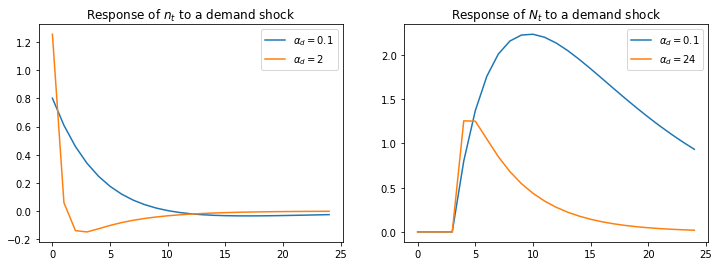

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(econ1.c_irf,label='$\\alpha_d = 0.1$')
ax1.plot(econ2.c_irf,label='$\\alpha_d = 2$')
ax1.legend()
ax1.set_title('Response of $n_t$ to a demand shock')

ax2.plot(econ1.h_irf[:, 0], label='$\\alpha_d = 0.1$')
ax2.plot(econ2.h_irf[:, 0], label='$\\alpha_d = 24$')
ax2.legend()
ax2.set_title('Response of $N_t$ to a demand shock')
plt.show()

The next figure plots the impulse response of $n_t$ (on the left)
and $N_t$ (on the right) to a positive demand shock, for
$k=4$, $k=7$ and $k=10$ (with $\alpha_d = 0.1$)

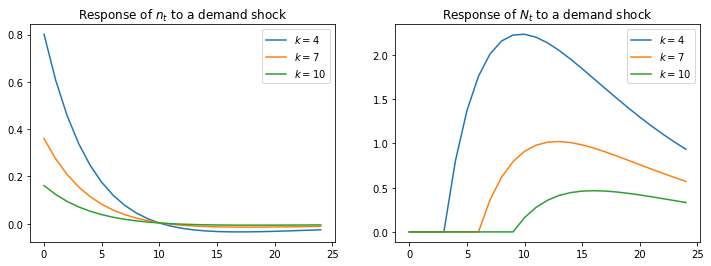

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(econ1.c_irf, label='$k=4$')
ax1.plot(econ3.c_irf, label='$k=7$')
ax1.plot(econ4.c_irf, label='$k=10$')
ax1.legend()
ax1.set_title('Response of $n_t$ to a demand shock')

ax2.plot(econ1.h_irf[:,0], label='$k=4$')
ax2.plot(econ3.h_irf[:,0], label='$k=7$')
ax2.plot(econ4.h_irf[:,0], label='$k=10$')
ax2.legend()
ax2.set_title('Response of $N_t$ to a demand shock')
plt.show()

Both panels in the above figure show that raising $k$ lowers the effect of
a positive demand shock on entry into the engineering profession.

Increasing the number of periods of schooling lowers
the number of new students in response to a demand shock.

This occurs because  with longer required schooling, new students ultimately benefit less from the impact of that shock on wages.